# Setup

## Imports

In [1]:
from typing import Dict, Tuple, Any
from itertools import chain

from matplotlib import pyplot as _plt
import numpy as _np

from pdkmaster.technology import primitive as _prm
from pdkmaster.design import circuit as _ckt, library as _lbry

from c4m.pdk import sky130
prims = sky130.tech.primitives
sky130cells = sky130.stdcelllib.cells

## PySpice

We use own compiled version of ngspice and set `NGPSICE_LIBRARY_PATH` accordingly. Reason is to use more recent version (>= 35) that speeds up the simulation wirh the ngspice decks. Also the provided `.spiceinit` file in the running directory is needed to get this speed up.

In [2]:
import os
os.environ["NGSPICE_LIBRARY_PATH"] = "/home/verhaegs/software/mint20/stow/ngspice-36/lib/libngspice.so"

from PySpice.Unit import *


## klayout

In [3]:
import pya
from pdkmaster.io.klayout import export as _klexp
ktech = pya.Technology.technology_by_name("Skywater_S8")
ksaveopts = ktech.save_layout_options.dup()
ksaveopts.write_context_info = False

# DAC design

Previously already a design of a SAR ADC has been made. This circuit already contained a capacitive DAC as a subcircuit.
In this exercise we will then focus on a R-2R DAC.

In [4]:
from c4m.pdk.sky130.dac import *

lib = _lbry.Library(name="daclib", tech=sky130.tech, cktfab=sky130.cktfab, layoutfab=sky130.layoutfab)


In [5]:
bits = 8

corner = ("logic_tt", "rc_tt")
vdd = 1.8

td = 10e-9
tr = 200e-12

dac = R2R_DAC(lib=lib, bits=bits, resistor=prims.poly_res, res_height=25, inv=sky130cells.inv_x1)

In [6]:
tb = sky130.pyspicefab.new_pyspicecircuit(top=dac.circuit, corner=corner)

tb.V("vdd", "vdd", "vss", vdd)
tb.V("vss", "vss", tb.gnd, 0.0)

for n in range(bits):
    name = f"bit_n[{n}]"
    tb.PieceWiseLinearVoltageSource(name, name, "vss", dc=vdd, values=(
        (0.0, vdd),
        ((n + 1)*td, vdd),
        ((n + 1)*td + tr, 0.0),
    ))
    
tb.C("vout", "vout", "vss", 50e-15)

sim = tb.simulator()
trans = sim.transient(end_time=(bits + 1)*td, step_time=0.5*tr)

Unsupported Ngspice version 36


Text(0, 0.5, 'vout [V]')

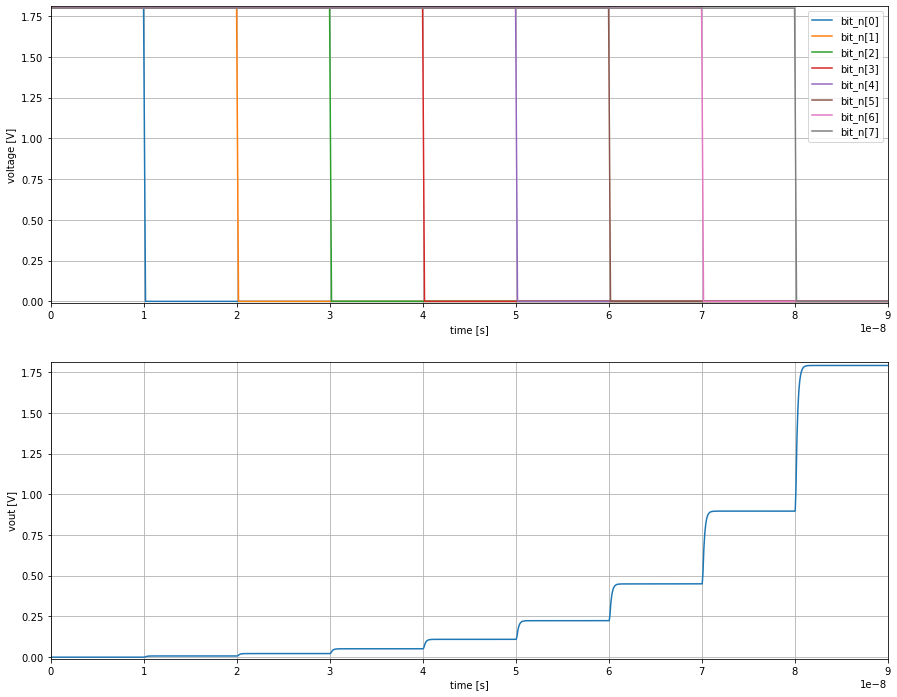

In [7]:
_plt.figure(figsize=(15, 12))

_plt.subplot(2, 1, 1)
for n in range(bits):
    name = f"bit_n[{n}]"
    _plt.plot(trans.time, trans.nodes[name], label=name)
_plt.axis((0.0, (bits + 1)*td, -0.01, 1.81))
_plt.legend()
_plt.grid(True)
_plt.xlabel("time [s]")
_plt.ylabel("voltage [V]")

_plt.subplot(2, 1, 2)
_plt.plot(trans.time, trans.vout)
_plt.axis((0.0, (bits + 1)*td, -0.01, 1.81))
_plt.grid(True)
_plt.xlabel("time [s]")
_plt.ylabel("vout [V]")


# Export

In [8]:
lib.cells["R2R_DAC"] = dac

file_name = "daclib.gds"
klay1v8db = _klexp.export2db(
    obj=lib, add_pin_label=True, gds_layers=sky130.gds_layers, cell_name=None, merge=True,
)
klay1v8db.write(file_name, ksaveopts)

!ls -l $file_name

-rw-rw-r-- 1 verhaegs verhaegs 14860 okt 31 11:09 daclib.gds
